In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.datasets as datasets  
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
import re
expr = pd.read_csv('/home/ubuntu/Optigon_dataset4VAE.csv',index_col=0)
print(expr)

                            Ust  Rab32     Sf3b5   Phactr2     Fuca2  Aig1  \
AAACCCATCTTCCGTG-1-0   0.000000    0.0  0.000000  0.000000  0.000000   0.0   
AAACGAACAGAGGAAA-1-0   1.734162    0.0  0.000000  1.734162  0.000000   0.0   
AAACGAATCGGCATCG-1-0   0.000000    0.0  0.000000  0.000000  0.000000   0.0   
AAACGCTAGGCATCAG-1-0   0.000000    0.0  0.000000  0.000000  0.000000   0.0   
AAACGCTAGTCGCTAT-1-0   0.000000    0.0  0.968499  0.968499  0.000000   0.0   
...                         ...    ...       ...       ...       ...   ...   
TTTGTTGAGCACTAAA-1-19  0.000000    0.0  0.000000  0.000000  0.000000   0.0   
TTTGTTGTCACCATAG-1-19  0.000000    0.0  0.000000  0.000000  0.000000   0.0   
TTTGTTGTCACTGTCC-1-19  0.000000    0.0  0.000000  0.000000  0.000000   0.0   
TTTGTTGTCCGCTAGG-1-19  0.000000    0.0  0.000000  0.000000  1.567588   0.0   
TTTGTTGTCTGGTTGA-1-19  0.000000    0.0  0.000000  0.000000  0.000000   0.0   

                       Adgrg6  AABR07000398.1    Cited2    Abra

In [3]:
from torch.utils.data import Dataset
import numpy as np
class snRNASeqDataset(Dataset):
    def __init__(self,exprMat):
        self.exprMat = exprMat.iloc[:,:-1].astype(float)
        self.labels = exprMat.iloc[:,-1]
        
    def __len__(self):
        return(len(self.labels))
    
    def __getitem__(self,idx):
        exprVector = np.array(self.exprMat.iloc[idx,:])
        label = self.labels[idx]
        return exprVector,label

In [5]:
dataset = snRNASeqDataset(expr)
print(len(dataset))

84221


In [6]:
dataset[1][0].shape

(2846,)

In [7]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
INPUT_DIM = 2846
Z_DIM = 10
H_DIM = 200
NUM_EPOCHS = 10
BATCH_SIZE = 64
LR_RATE = 3e-4

cpu


In [8]:
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, z_dim, h_dim=200):
        super().__init__()
        # encoder
        print(input_dim)
        print(h_dim)
        self.img_2hid = nn.Linear(input_dim, h_dim)

        # one for mu and one for stds, note how we only output
        # diagonal values of covariance matrix. Here we assume
        # the pixels are conditionally independent 
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.img_2hid(x))
        mu = self.hid_2mu(h)
        sigma = self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        new_h = F.relu(self.z_2hid(z))
        x = torch.sigmoid(self.hid_2img(new_h))
        return x

    def forward(self, x):
        mu, sigma = self.encode(x)
        sigma = torch.exp(sigma)

        # Sample from latent distribution from encoder
        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*epsilon

        x = self.decode(z_reparametrized)
        return x, mu, sigma


In [10]:
# Define train function
def train(num_epochs, model, optimizer, loss_fn):
    # Start training
    for epoch in range(num_epochs):
        loop = tqdm(enumerate(train_loader))
        for i, (x, y) in loop:
            # Forward pass
            x = x.to(device).view(-1, INPUT_DIM).float()
            x_reconst, mu, sigma = model(x)

            # loss, formulas from https://www.youtube.com/watch?v=igP03FXZqgo&t=2182s
            reconst_loss = loss_fn(x_reconst, x)
            kl_div = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

            # Backprop and optimize
            loss = reconst_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())


In [11]:
# Initialize model, optimizer, loss
model = VariationalAutoEncoder(INPUT_DIM, Z_DIM, H_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")

2846
200


In [12]:
# Run training
train(NUM_EPOCHS, model, optimizer, loss_fn)

1316it [00:40, 32.39it/s, loss=-1.13e+5]
1316it [00:40, 32.73it/s, loss=-1.46e+5]
1316it [00:40, 32.66it/s, loss=-1.6e+5] 
1316it [00:43, 30.35it/s, loss=-1.47e+5]
1316it [00:40, 32.56it/s, loss=-1.74e+5]
1316it [00:40, 32.61it/s, loss=-1.72e+5]
1316it [00:44, 29.80it/s, loss=-1.78e+5]
1316it [00:41, 31.70it/s, loss=-1.82e+5]
1316it [00:41, 31.95it/s, loss=-1.56e+5]
1316it [00:42, 31.16it/s, loss=-1.59e+5]


In [24]:
# Get Mu's and Sigma's for each image
mus = []
sigmas = []
for vector,label in dataset:
    with torch.no_grad():
        mu, sigma = model.encode(torch.from_numpy(np.float32(vector)))
        mus.append(mu)
        sigmas.append(torch.exp(sigma))

float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


In [25]:
rows = []
labels = []
for i,(vector,label) in enumerate(dataset):
    labels.append(label)
    rows.append(pd.Series(np.array(mus[i]).reshape((10,)),name='vector%d' % i))

df = pd.concat(rows,join='inner',axis=1).transpose()
print(df.shape)
labels = pd.Series(labels,index=df.index)
df = pd.concat([df,labels],join='inner',axis=1)
df.columns = ['latent'+str(i) for i in df.columns[:-1]] + ['Label']
print(df)

(84221, 10)
              latent0   latent1   latent2   latent3   latent4   latent5  \
vector0      2.109046 -0.702676  0.948190  1.566961 -0.923676 -1.186957   
vector1      0.817562  1.134942  1.023678  0.103145 -0.382533 -1.037282   
vector2      2.257565 -0.813465  1.401861  1.272856  0.319223  0.756078   
vector3      1.361377  1.161396  1.354657 -0.093969  0.069869 -1.145803   
vector4      0.184390  2.372838  0.944506  0.093719  0.169661  0.186314   
...               ...       ...       ...       ...       ...       ...   
vector84216  0.692953 -2.280169  0.119541 -0.309365  0.518047 -0.117720   
vector84217 -0.240876 -0.004654  1.376206  0.425607 -0.484854  0.653912   
vector84218  0.275032 -2.633216  0.970015  0.512412  1.052402  1.092657   
vector84219 -1.410975  3.359850  1.681442  1.632964  0.207611  0.766954   
vector84220 -1.023836 -2.319801  0.736586 -0.375392 -0.325800  0.133461   

              latent6   latent7   latent8   latent9             Label  
vector0     -1.

In [26]:
from sklearn.manifold import TSNE
embedding = TSNE(perplexity=20,metric='euclidean').fit_transform(df.iloc[:,:-1])
embedding = pd.DataFrame(embedding,index=df.index,columns=['TSNE1','TSNE2'])
df2 = pd.concat([embedding,df['Label']],join='inner',axis=1)
print(df2)

                 TSNE1      TSNE2             Label
vector0       2.126128   8.104450         GC-Antral
vector1     -14.023444   6.739216         GC-Antral
vector2      23.685509   7.485572  GC-Proliferating
vector3     -17.334740   5.194792         GC-Antral
vector4     -22.792179   2.340124         GC-Antral
...                ...        ...               ...
vector84216  27.562252  27.065062  GC-Proliferating
vector84217  -1.449239  -2.765375         GC-Antral
vector84218  36.712215   0.576888  GC-Proliferating
vector84219 -24.784828 -41.522945             Theca
vector84220  16.825546  19.621569      GC-Preantral

[84221 rows x 3 columns]


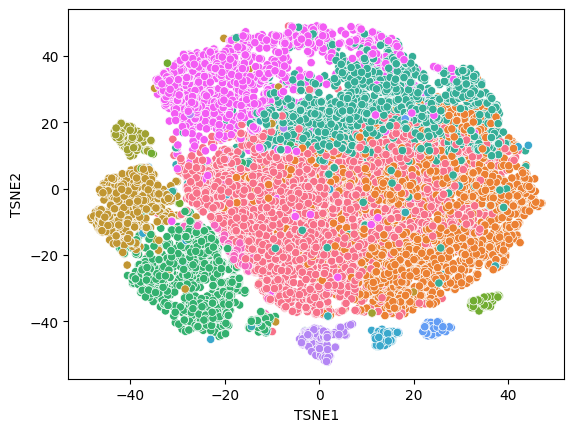

In [32]:
import seaborn as sns
df3 = df2.iloc[:20000,:].copy()
sns.scatterplot(x='TSNE1',y='TSNE2',hue='Label',data=df3)
plt.gca().get_legend().remove()

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

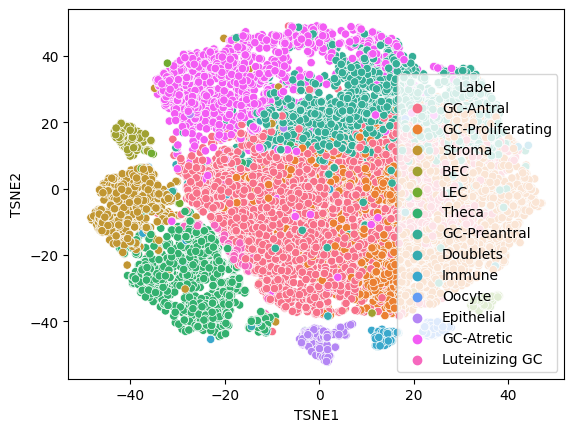

In [33]:
df3 = df2.iloc[:20000,:].copy()
sns.scatterplot(x='TSNE1',y='TSNE2',hue='Label',data=df3)